In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [3]:
from scipy.spatial.distance import pdist, squareform
def VAT(R):
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)
    
    I = i[j]
    del J[I]
    
    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    C = [1,1]

    for r in range(2, N-1):
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)
        y = np.min(y)
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])

    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)

    I.extend(J)
    C.extend(i)

    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    return RV.tolist(), C, I


def entropy(probs):
    
    return -probs.dot(np.log2(probs))


def mutual_info(df):
    
    Hx = entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    counts = df.groupby(list(df.columns.values)).size()
    probs = counts/ counts.values.sum()
    H_xy = entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy) #I_xy/np.sqrt(H_x*H_y)
    
    return {'H_'+list(df)[0]:Hx,'H_'+list(df)[1]:Hy,'MI':MI,'NMI':NMI} 


In [4]:
food =  pd.read_csv("food_nutrient_2011_13_AHS.csv", header=0,low_memory=False)
food

,Food ID,Survey ID,Food Name,Survey flag,"Energy, with dietary fibre (kJ)","Energy, without dietary fibre (kJ)",Moisture (g),Protein (g),Total fat (g),"Available carbohydrates, with sugar alcohols (g)",...,Total saturated fat (g),Total monounsaturated fat (g),Total polyunsaturated fat (g),Linoleic acid (g),Alpha-linolenic acid (g),C20:5w3 Eicosapentaenoic (mg),C22:5w3 Docosapentaenoic (mg),C22:6w3 Docosahexaenoic (mg),Total long chain omega 3 fatty acids (mg),Total trans fatty acids (mg)
0,10F40019,31103001,"Beef, extract, bonox",NaN,401,401,56.6,16.6,0.2,6.5,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000,0.00
1,13A12001,31302001,"Basil, dried",NaN,1079,774,10.0,18.2,5.5,15.5,...,2.36,1.40,0.61,0.26,0.34,0.00,0.00,0.0,0.000,0.00
2,10E10113,31302002,"Cardamom, seeds, ground",NaN,1333,1109,8.3,10.8,6.7,40.5,...,2.20,2.81,1.39,1.00,0.39,0.00,0.00,0.0,0.000,0.00
3,10E10098,31302003,Chilli (chili) powder,NaN,1441,1167,7.8,12.3,16.8,20.5,...,2.41,3.15,7.85,7.32,0.52,0.00,0.00,0.0,0.000,0.00
4,10E10107,31302004,"Chilli (chili), dried, ground",NaN,1573,1355,6.6,14.1,16.8,29.6,...,2.42,3.16,7.89,7.36,0.52,0.00,0.00,0.0,0.000,0.00
5,10E10099,31302005,"Cinnamon, dried, ground",NaN,1026,591,9.8,4.2,2.7,25.5,...,1.35,0.96,0.22,0.17,0.04,0.00,0.00,0.0,0.000,0.00
6,10E10106,31302006,"Cloves, dried, ground",NaN,1536,1262,5.9,6.0,17.3,30.8,...,4.69,1.83,9.49,3.53,0.81,11.90,254.15,0.0,266.044,0.00
7,10E10100,31302007,"Coriander seed, dried, ground",NaN,1476,1125,6.1,13.0,19.8,10.5,...,1.11,15.79,2.04,2.04,0.00,0.00,0.00,0.0,0.000,0.00
8,10E10093,31302008,"Cumin (cummin) seed, dried, ground",NaN,1915,1831,7.3,18.4,25.8,33.3,...,1.80,18.37,4.29,4.06,0.23,0.00,0.00,0.0,0.000,0.00
9,10E10096,31302009,Curry powder,NaN,1459,1242,9.5,12.7,13.8,30.9,...,2.85,7.08,3.33,2.70,0.63,0.00,0.00,0.0,0.000,0.00


In [5]:
##Question 1


###1a
newFood = food.loc[:, 'Energy, with dietary fibre (kJ)':'Total trans fatty acids (mg)'] # select the continous features from food dataframe


###1b
scaler = StandardScaler(copy = True, with_mean = False, with_std = True)
foodscaled = scaler.fit_transform(newFood.astype("float64")) # transfomation, set newfood to float 64 to avoid warning

###1c
numRows = foodscaled.shape[0]
numColumns = foodscaled.shape[1]
minvalue = foodscaled.min().min() # find the min for all value
maxvalue = foodscaled.max().max() # find the max for all value
meanvalue = foodscaled.mean().mean() # find the mean for all value
stdvalue = scaler.transform(newFood.astype("float64")).std()

print("***\nQ1.c: foodscaled matrix details")
print("Number of rows: {:.1f}".format(numRows))
print("Number of columns: {:.1f}".format(numColumns))
print("Min: {:.1f}".format(minvalue))
print("Max: {:.1f}".format(maxvalue))
print("Mean: {:.1f}".format(meanvalue))
print("Standard Deviation: {:.1f}".format(stdvalue))
print("***")

***
Q1.c: foodscaled matrix details
Number of rows: 5740.0
Number of columns: 53.0
Min: 0.0
Max: 75.8
Mean: 0.5
Standard Deviation: 1.1
***


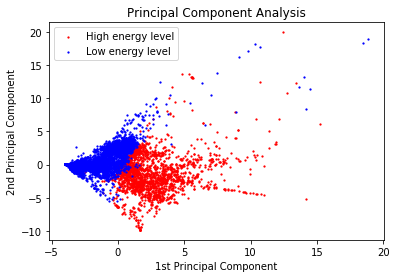

In [6]:
#Question 2


###2a
foodscaled = pd.DataFrame(data = foodscaled) # convert the nparray back into dataframe

EnergyLevel = list() # create a new list for energy level
for i in range(numRows):
    # if energy greater than 1000, energy level = 1
    if (newFood.loc[i, 'Energy, with dietary fibre (kJ)'] > 1000):
        EnergyLevel.append(1)
    # less than -> energy level = 0
    else:
        EnergyLevel.append(0)
# add the new feature into the original dataframe food
food['EnergyLevel'] = EnergyLevel

###2b
pca = PCA(n_components=2) # set the PCA components to 2 as required
foodreduced = pca.fit_transform(foodscaled) # transform the data to reduced components 

###2c

# convert nparray foodreduced into dataframe
foodreduced = pd.DataFrame(foodreduced)

# find the food with high energy level and low energy level corresponding to EnergyLevel attribute
food_high=foodreduced.loc[food['EnergyLevel']==1]
food_low=foodreduced.loc[food['EnergyLevel']==0]

fig, ax = plt.subplots()

# plot the graph according to their energy level
# high energy level in red, low energy level in blue
ax.scatter(food_high[0], food_high[1], color='red', label='High energy level',s=1.5)
ax.scatter(food_low[0],food_low[1], color='blue',label='Low energy level',s=1.5)
leg = ax.legend() # plot the colour legend

# specify x,y labels
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('Principal Component Analysis')
plt.show()


Question 2d answer here

The scatter plot of Principal Component Analysis overall shows a posivite correlation with two clusters which are differ by their energy levels. Indicating that food energy level is correlated to food's nutrient contents. Below is the interpretation.

Mostly, the data points are concentrated at the left bottom part of the plot and distributed towards the right upper corner, showing some symmetrical relationship along the diagonal. For example, the points with low energy level are more closer to the 2nd Principal Component axis, as well as a sharp point that points to the 2nd Principal Component axis, while the points with high energy level are more closer to the 1st Principal Component axis, and there is a sharp point which points to the 1st Principal Component axis as well. This shows that foods with high energy level are more correlated with the 1st Pricipal Component, while the foods with low energy level are more correlated with the 2nd, and thus supports that food energy level is correlated to food's nutrient contents since 1st and 2nd Principal Components are generated from those nutrient contents.

Advantages: Reduced the features of the original food dataset, generates two principal components that is representable of the high dimensional dataset, make the relationship between food's netrient and energy level visible.

Disadvantages: Since PCA generates two new features from the original features, and none of the original features is visible from the two generated pricipal components, the scatter plot is unable to represent the relationship of which specific food nutrient has higher effect on food's energy level.

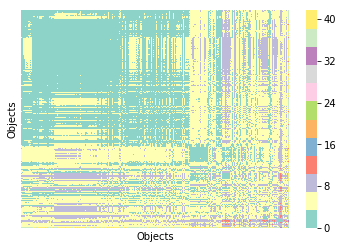

In [7]:
#Question 3


###3a
SurveyID = food.loc[:, 'Survey ID'].astype(str) # convert survey ID to type string for string slice
FoodCategory = SurveyID.str.slice(start=0, stop=2, step=1) # create a new feature with only first two letters of surveyID
food['Food category'] = FoodCategory # add foodCategory into foodscaled as a new column

###3b
foodscaledsample = pd.DataFrame() # create a new dataframe
for i in range(numRows):
    # if foodCategory is 13, 20 or 24, select the whole row and add it to foodscaledsample
    if food.loc[i, 'Food category'] == '13' or food.loc[i, 'Food category'] == '20' or food.loc[i, 'Food category'] == '24':
        foodscaledsample = foodscaledsample.append(foodscaled.loc[i, :])

###3c
RV, R, I = VAT(foodscaledsample)

###3d

x = sns.heatmap(RV, cmap='Set3', xticklabels=False, yticklabels=False)
x.set(xlabel='Objects', ylabel='Objects')
plt.show()

Question 3e here

There are two clusters that are apparent in this heatmap which is not what we expected. For this foodscaledsample dataset, we chose food from food category 13, 20 and 24 as samples, therefore, three clusters are expected. This might due to the foods in food category 20 and 24 may have similar properties which make them grouped together and hard to distinguish from the heat map. 

Since colormaps are often split into several categories based on their function, such as sequential, diverging and qualitative where each of them has different focus on the dataset, use of different colormaps according to the properties of the dataset, such as whether their information has ordering, a critical middle value or does not have obvious ordering or relationships can have different visualisations of the heatmap then produce different usefulness. 

For example, in this heatmap, the main coloring is focused on the 0 to 8 range of the color bar and the information about food nutrient presented in foodscaledsample is neither has ordering nor a critical middle value, therefore, a qualitative colormap with color varies along the 0 to 8 range should be chosen for this heatmap for a better visualisation.

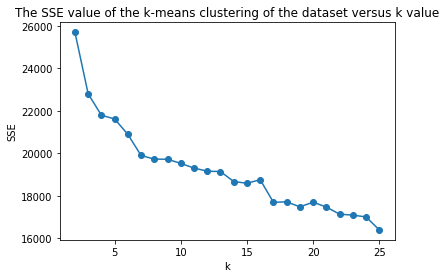

In [8]:
#Question 4

###4a 
sse = [] # a list for storing the Sum
for k in range(2, 26):
    # find the clusters for each k-means clustring
    kmeans = KMeans(n_clusters = k, random_state = 100).fit(foodscaled) # random_state = 100 as requried
    # calculating the euclidean distance from each datapoint in foodscaled to the Kmeans
    # then find the min value of those points and add them up to find the clusters
    sse.append(sum(np.min(cdist(foodscaled, kmeans.cluster_centers_, 'euclidean'), axis=1))) #/ foodscaled.shape[0]) 

# plot the graph
plt.plot(range(2, 26), sse, marker = 'o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title("The SSE value of the k-means clustering of the dataset versus k value")
plt.show()

Question 4b answer here

The plot shows that as the number of clusters increases, the sum of square erros decreases, it is an arm like chart with two obvious elbows at k = 7 and k = 17. This is not what we expected since the dataset of the food has food categories arrange from 11 to 34, which means those foods are expected to be divided into 23 clusters.

This might due to the foods in some of the food categories may have similar properties and contents, so those food categories can be considered as a whole cluster. As for the two elbows in the graph, although there is only one elbow that is expected to appear, divide the dataset into 7 or 17 clusters might both have meanings according to the contents of the food's features.

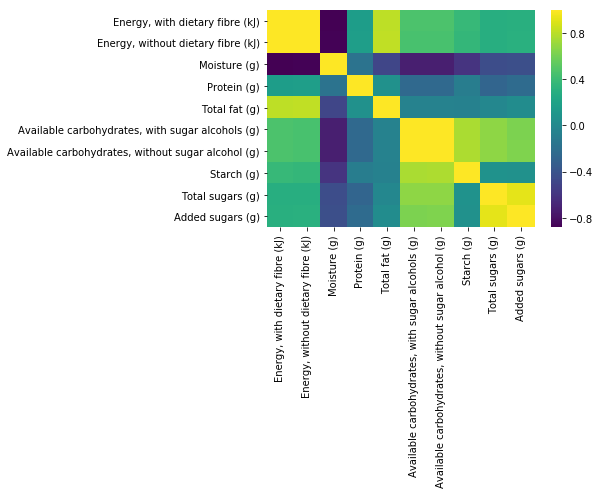

In [9]:
###Question 5


###5a
# extract the required attributes from food
first10food = food.iloc[:, 4:14]
# find the correlation of first10food
corr = first10food.corr()

corr_heatmap = sns.heatmap(corr, cmap = 'viridis', xticklabels = corr.columns, yticklabels = corr.columns)
plt.show()

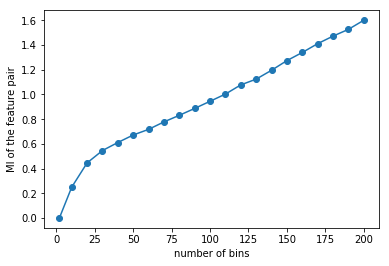

In [10]:
## 5b code

# adjust my_entropy from the example one:
# make sure the 0 values is skipped
def my_entropy(x):
    value = 0
    for i in x:
        # escape the 0 values which gives log an error
        if(i != 0 ):
            value -= i*np.log2(i)
    return value

# calculate the mutual information from the input dataframe
# make use of the function my_entropy
def mutual_info(df):
    
    Hx = my_entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = my_entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    counts = df.groupby([df.columns.values[0],df.columns.values[1]]).size()
    probs = counts/ counts.values.sum()
    H_xy = my_entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    
    return MI

# a function to calculate mutual information for given bins and features
def calc_MI(x, y, bins):
    # cut x by number of bins and put it into a series
    x_cut = pd.Series(pd.cut(x, bins))
    # cut y by number of bins and put it into a series
    y_cut = pd.Series(pd.cut(y, bins))

    # combine x_cut and y_cut into a dataframe and put it into function mutual_info to find the MI value
    return mutual_info(pd.concat([x_cut, y_cut], axis=1))

# extract the requried two columns from the food dataframe
ProteinAndEnergy = food.loc[:, ['Protein (g)', 'Energy, with dietary fibre (kJ)']]

# create the equal-width bins first
numbersOfBins = [2]
for i in range(1, 21):
    numbersOfBins.append(10*i)

# a list for storing MIvalue
MIvalue = []

# for each width's bin
for i in range(len(numbersOfBins)):
    # here, ProteinAndEnergy.iloc[:, 0] means selecting all the rows from Protein column
    # while [;, 1] means selecting all the rows from Energy column
    # then put in each bin size and get the corresponding MI value
    MIvalue.append(calc_MI(ProteinAndEnergy.iloc[:, 0], ProteinAndEnergy.iloc[:, 1], numbersOfBins[i]))

# convert the array into a series
MIvalues = pd.Series(MIvalue)
# name the series's index with corresponding number of bins
MIvalues.index = numbersOfBins

plt.plot(MIvalues, marker = 'o')
plt.xlabel('number of bins')
plt.ylabel('MI of the feature pair')
plt.show()

Question 5b comment here

In this plot, we can observe a rapid increasing of MI values while number of bins increases from 2 to 20, after the number of bins reaches 20, the MI values are still growing but just in a slower tendency.

This trend can be considered as the fact that there are only 23 food categories in this dataset, and those food's 'Protein' and 'Energy, with dietary fibre' features are correlated to their categories, therefore, as the number of bins reaches the number of different food categories, the growth rate of MI value decreases. Although the MI values are still increasing which means the data does become more correlated, this is just similar to the SSE plot we drawn before where we are actually dividing the dataset into more micro and specific parts.

In [11]:
###5c code

############ pearson correlation #################

# find the pearson correlation matrix for newFood (the one with 53 continous features)
pearsonFood = newFood.corr(method='pearson')
# give the correlation with self columns an impossible value as -2
for i in range(pearsonFood.shape[0]):
    pearsonFood.iloc[i, i] = -2
# sort the matrix in decending order, drop duplicated values then find the top 10 values
pearsonFood = pearsonFood.unstack().sort_values(ascending = False).drop_duplicates()[:10]

############ Mutual Information #################

n = newFood.shape[1] # find the number of features newFood has
matMI = np.zeros((n, n)) # create an empty matrix with n rows and n columns

# iterate along the upper triangle of the matrix matMI
for i in range(n):
    for j in range(i+1):
        # escape the mutual inforamtion calculated with self columns
        if (i != j):
            # calculate the MI value by the functino calc_MI above, add it into the matrix
            matMI[i,j] = calc_MI(newFood.iloc[:,i], newFood.iloc[:,j], 20) # using 20 equal-wdith bins

# convert the matrix into a dataframe with index/columns
matMI = pd.DataFrame(matMI)
matMI = matMI.set_index(newFood.columns.values)
matMI.columns = newFood.columns.values
# sort the matrix in decending order, drop dul=plicated values then find the top 10 values
matMI = matMI.unstack().sort_values(ascending = False).drop_duplicates()[:10]

print("======pearson correlation======")
print(pearsonFood)
print("\n======MI======")
print(matMI)

======pearson correlation======
Vitamin E (mg)                                      Alpha-tocopherol (mg)                               0.999528
Energy, without dietary fibre (kJ)                  Energy, with dietary fibre (kJ)                     0.998608
Beta-carotene (µg)                                  Provitamin A (b-carotene equivalents) (µg)          0.995961
Available carbohydrates, without sugar alcohol (g)  Available carbohydrates, with sugar alcohols (g)    0.995466
Added sugars (g)                                    Free sugars (g)                                     0.988894
Dietary folate equivalents  (µg)                    Total Folates  (µg)                                 0.985763
Linoleic acid (g)                                   Total polyunsaturated fat (g)                       0.973640
Folic acid  (µg)                                    Dietary folate equivalents  (µg)                    0.958112
Vitamin A retinol equivalents (µg)                  Preformed vi

***
Q6.a: Train Test Split Results
X_train matrix: (4592, 53)
y_train labels: (4592,)
X_test matrix: (1148, 53)
y_test labels: (1148,)
***


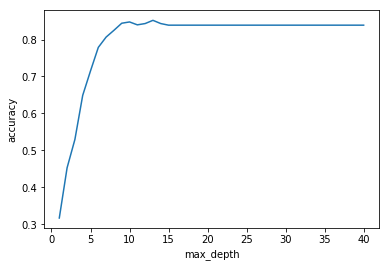

In [12]:
##Question 6


###6a

## convert data into type float
data = foodscaled.astype(float)

##get just the class labels
classlabel = food['Food category']

# get the requried value with train size 80% and test size 20%
X_train, X_test, y_train, y_test = train_test_split(data, classlabel, train_size=0.80, test_size=0.20, random_state=42)

print("***\nQ6.a: Train Test Split Results")
print("X_train matrix:", X_train.shape)
print("y_train labels:", y_train.shape) #如果不说shape[0]的话，output是 （4592，） 
print("X_test matrix:", X_test.shape)
print("y_test labels:", y_test.shape)
print("***")

###6b
from sklearn.tree import DecisionTreeClassifier

depthList = range(1, 41, 1) # create the max_depth values
accu_list = []
for depth in depthList:

    # get the decision tree classifier with one of the max_depth value
    dt = DecisionTreeClassifier(criterion="entropy",random_state=1, max_depth=depth)
    
    #normalise the data to have 0 mean and unit variance using the library functions.  This will help for later
    #computation of distances between instances
    scaler = StandardScaler().fit(X_train)
    X_train=scaler.transform(X_train)
    X_test=scaler.transform(X_test)
    # above-> preprocessing
    
    dt.fit(X_train, y_train)
    y_pred=dt.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    accu_list.append(score)
    
plt.plot(depthList, accu_list)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()


Question 6c comment here

The shape of the plot is like a cliff, where there is a rapid increasing of accuracy when max_depth of the decision tree increases from 1 to 10, then the accuracy has a weak drop down after it reaches max_depth = 10, after that, the accuracy increases again, and has created a local peak at around max_depth = 13, then the accuracy tends to become a horizontal line which means the increase of max_depth has no effect on the accuracy now.

The first rapid increasing trend of the accuracy from max_depth = 1 to 10 can be simply considered as adding more features for the model to learn which increases the accuracy of the test score. The horizontal line after max_depth = 13 may due to that there are already enough features for the model to learn, the rest of the adding features are just correlated to the previous ones, thus adding more features could not give the model more information to predict the outcomes.

As for the local peaks, there are two local peaks can be seen on the plot, one is at max_depth = 10, another is at max_depth = 13. Possible reasons may be there are some critical splits such as a detecting of a potential outlier which leads to the accuracy peak.

In [13]:
#Question 7

###7a
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
# use X_test to predict y_test 
# then compare the actual y_test and predicted one to find the test_accuracy
test_accuracy = accuracy_score(y_test, knn.predict(X_test))
# use X_train to predict y_train
# then compare the actual y_train and predicted one to find the train_accuracy
train_accuracy = accuracy_score(y_train, knn.predict(X_train))

print("***\nQ7a: Food category prediction using k-NN (k=1)")
print("Train accuracy: {}%".format(round(train_accuracy*100, 1)))
print("Test accuracy: {}%".format(round(test_accuracy*100, 1)))
print("***")


##7b
# exactly same process, except change n_neighbors to 3
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
test_accuracy = accuracy_score(y_test, knn.predict(X_test))
train_accuracy = accuracy_score(y_train, knn.predict(X_train))

print("***\nQ7b: Food category prediction using k-NN (k=3)")
print("Train accuracy: {}%".format(round(train_accuracy*100, 1)))
print("Test accuracy: {}%".format(round(test_accuracy*100, 1)))
print("***")

***
Q7a: Food category prediction using k-NN (k=1)
Train accuracy: 100.0%
Test accuracy: 90.0%
***
***
Q7b: Food category prediction using k-NN (k=3)
Train accuracy: 93.3%
Test accuracy: 87.7%
***


Question 7c comment here
Both outputs from part a) and b) have relatively high accuracy, while the output from part a) which is using k=1 has higher accuracy compare to the output from part b) which use k = 3. For k-NN prediction model, a smaller k means more sensitive to noise points, while a larger k means the neighborhood may include points from other classes, as for this dataset, the input data of foodscaled does not have a specific ordering or relationships, so the desired k value should be small to work well since the classification should be sensitive to noise points.

Question 7d comment here
Because the dataset input is already standarlized in question 1 with 0 means and variance, which narrow the gap between each datapoint. Therefore, since we first standarlized the data then split it, the accuracy is over-optimistic. For a more reliable accuracy the dataset should split into train and test dataset first and then does the standarlize processing.

In [14]:
#Question 8 code

foodscaled.columns = newFood.columns.values

## this block, calculated the producted value of each features

productedFeature = pd.DataFrame()

# find the product of each two features
for i in range(foodscaled.shape[1]):
    # jump the features that already timed
    for j in range(i, foodscaled.shape[1]):
        # make sure not include the self producted features
        if (i != j):
            productedFeature['{}*{}'.format(foodscaled.columns[i], foodscaled.columns[j])] = foodscaled[foodscaled.columns[i]]*foodscaled[foodscaled.columns[j]]

# combine new features and original features together into a new dataframe called combinedFood
combinedFood = pd.concat([foodscaled, productedFeature], axis=1, sort=False)

in k-NN = 3: 10 selected features in 10 bins has max train accuracy: 85.4%
in k-NN = 3: 10 selected features in 10 bins has max selected Test accuracy: 74.7%
in k-NN = 3: 210 selected features in 2 bins has max train accuracy: 92.3%
in k-NN = 3: 210 selected features in 100 bins has max selected Test accuracy: 86.8%
in k-NN = 3: 410 selected features in 2 bins has max train accuracy: 93.3%
in k-NN = 3: 410 selected features in 90 bins has max selected Test accuracy: 86.8%
in k-NN = 3: 610 selected features in 20 bins has max train accuracy: 93.5%
in k-NN = 3: 610 selected features in 70 bins has max selected Test accuracy: 87.2%
in k-NN = 3: 810 selected features in 30 bins has max train accuracy: 93.4%
in k-NN = 3: 810 selected features in 70 bins has max selected Test accuracy: 87.1%
in k-NN = 3: 1431 selected features in 10 bins has max train accuracy: 93.3%
in k-NN = 3: 1431 selected features in 20 bins has max selected Test accuracy: 87.3%
in k-NN = 3: overall 610 selected feature

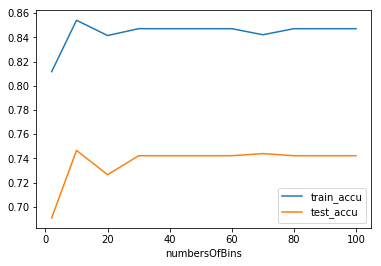

In [42]:
### this block of code for getting the top 10 features
### by applying mutual information to combinedFood with food category

classLabel = food['Food category'].astype(float)

# create the equal-width bins first
numbersOfBins = [2]
for i in range(1, 11):
    numbersOfBins.append(10*i)    
    
# create a list for range of selected features
numbersOfFeatures = []
for i in range(10, 1000, 200):
    numbersOfFeatures.append(i)
numbersOfFeatures.append(combinedFood.shape[1]) # finally, import all the features to train the model
    
# create a list to store the train and test accuracy for each bin
train_accu = []
test_accu = []

# two variables that used to find the maximum accuracy
global_max_train = 0
global_max_test = 0
global_max_test_bin = 0
global_max_train_bin = 0
max_train_feature = 0
max_test_feature = 0
# set firstRun in gloabl to True to make sure that block of code will only run once
firstRun = True

for topfeatures in numbersOfFeatures:    
    
    # local variables to store maximum 
    max_train = 0
    max_test = 0
    max_text_bin = 0
    max_train_bin = 0  
    
    for bins in numbersOfBins:
        # create a series of MI values that stores the MI values of each feature (combinedFood.iloc[:, i]) and class pair (food category)
        lstMI = []
        # iterate along the features in combinedFood
        for i in range(combinedFood.shape[1]):
            # calculate the MI values for features and class labels
            # use the current bin size
            lstMI.append(calc_MI(combinedFood.iloc[:, i], classLabel, bins))

        # convert the matrix into a dataframe with index/columns
        dfMI = pd.DataFrame(lstMI)
        dfMI = dfMI.set_index(combinedFood.columns.values)
        # set the column names to '' since there has no pair feature
        dfMI.columns = ['']
        # sort the matrix in decending order, drop dulplicated values then find the top values
        featuredMI = dfMI.unstack().sort_values(ascending = False).drop_duplicates()[:topfeatures]

        ### this block of code for calculating the accuracy by using the top value's corresponding selected features

        # create an empty list to store the selected features from the top featrues
        selectedFeatures = []

        # add each features (remove duplicats) into the list
        # the skip argument is just for skip the '' index name infront of each feature
        for (skip, feature) in featuredMI.index:
            if feature not in selectedFeatures:
                selectedFeatures.append(feature)

        ## get just the selected features from combined food dataframe
        # use those selected features to train the data
        data = combinedFood[selectedFeatures].astype(float)

        ##get just the class labels
        classlabel = food['Food category']

        # get the requried value with train size 80% and test size 20%
        X_train, X_test, y_train, y_test = train_test_split(data, classlabel, train_size=0.80, test_size=0.20, random_state=42)

        knn = KNeighborsClassifier(n_neighbors = 3)
        knn.fit(X_train, y_train)
        selected_test_accuracy = accuracy_score(y_test, knn.predict(X_test))
        selected_train_accuracy = accuracy_score(y_train, knn.predict(X_train))

        # append the accuracy values into the list
        train_accu.append(selected_train_accuracy)
        test_accu.append(selected_test_accuracy)

        # check if this is the maximum accuracy
        if (selected_train_accuracy > max_train):
            max_train = selected_train_accuracy
            max_test_bin = bins
        if (selected_test_accuracy > max_test):
            max_test = selected_test_accuracy
            max_train_bin = bins

            
    # check for this selected top features, if the train and test value are maximum values
    if (max_train > global_max_train):
        global_max_train = max_train
        global_max_train_bin = max_train_bin
        max_train_feature = topfeatures
    if (max_test > global_max_test):
        global_max_test = max_test
        global_max_test_bin = max_test_bin
        max_test_feature = topfeatures
        
    ## the next block of code is used to draw the graph between number of bins and accuracy
    ## to avoid it been drawn multiple times, a boolean firstRun is used
    if firstRun is True:   
        # concate the train_accu list and test_accu list into a dataframe and plot them into a graph
        accu_df = pd.concat([pd.Series(numbersOfBins), pd.Series(train_accu), pd.Series(test_accu)], axis=1, sort=False)
        accu_df.columns = ['numbersOfBins', 'train_accu', 'test_accu']
        accu_df = accu_df.set_index('numbersOfBins')
        lines = accu_df.plot.line()
        # then set firstRun to False to prevent next running
        firstRun = False
    
    print("in k-NN = 3: {} selected features in {} bins has max train accuracy: {}%".format(topfeatures, max_train_bin, round(max_train*100, 1)))
    print("in k-NN = 3: {} selected features in {} bins has max selected Test accuracy: {}%".format(topfeatures, max_test_bin, round(max_test*100, 1)))

print("===========================================================================")
print("in k-NN = 3: overall {} selected features in {} bins has global max train accuracy: {}%".format(max_train_feature, global_max_train_bin, round(global_max_train*100, 1)))
print("in k-NN = 3: overall {} selected features in {} bins has global max test accuracy: {}%".format(max_test_feature, global_max_test_bin, round(global_max_test*100, 1)))
      

Question 8 discussion here

The feature selection + generation process could deliver an accuracy boost compare to the original train accuracy (93.3%) on k-NN = 3 to 93.5%, but cound not deliver an accuracy boost on test accuracy.

According to the output data, we can observe that for a feature selection range from 10 to 1000 in a step of 200 and with a bin size varying from 2 to 100 in a step size of 10, as the number of feature selected increases, the overall accuracy increases. In additional, according to the plot of number of bins verses accuracy graph, for bin size ranging from 2 to 30, the increase of bin size does have an impact on the accuracy, although there has no clear linear relationship between them. And we can figure out from the text output that the best-fit bin size for each selected top feature varies randomly as well, which also determines that there is no linear relationship between these two arguments.

And as we adjust the number of features selected, we observe that the more features selected to put into the training model, the more accurate the predicted data is. However, as the imported features reaches 610, the accuracy has a slightly drop down. If we input top 10 features, the maximum occurs with bin size = 10, and the output accuracy is 85.4% and 74.7% respectively. If we input the top 210 features with best-fit bin sizes 2 and 100, the accuracy boosts to 92.3% and 86.8% and if we input the top 610 features with best-fit bin sizes 20 and 70, the accuracy boosts to 93.5% and 87.2%. At this point, the train accuracy does get higher than the original output (93.3%). However, as we import more features, such as 810 and 1431, the train accuracy drops to 93.4% and 93.3%, but the test accuracy does increase to 87.3%.

Overall, we cannot observe a strong accuracy boosts and selecting all the features and testing each bin size is really memory and time consuming. The low boosts might due to the method we chose for creating additional features and the properties of the original data we have. Since our foodscaled dataset has no ordering between each individual features (except there are some features that have very correlated attributes, such as 'added sugar' and 'free sugar') and the value range for foodscaled is from 0 to 75.8 which is relatively small compare to such a large dataset. Therefore, adding features by simply multiplying them together may create features with similar values that can mislead the model's training since the new feature has no meaning on neither the class label nor the original features, especially when there are features that could have value 0, such as some foods do not have any 'added sugar', if we time those features with any other feature, we will only get 0, this is obviously not what we expect. Which can be considered as the reason of why putting more features into the prediction model will drop down the accuracy, because in the bottom part of the MI value list, the left pairs are less correlated, therefore, putting those datas in can sometimes mislead the decision tree therefore reduce the accuracy. By the way, the divide method was not chosen for adding additional features is due to those value 0 features as well, as the denominator cannot be 0 and if we do so, a runtime error will occur.